In [1]:
from database.database import MediumArticle, URL, Comment, Author
from database.database import get_session
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
from sqlalchemy import func

In [2]:
session = get_session()

## Set up data

In [3]:
# query all articles
articles_df = pd.read_sql(session.query(MediumArticle).statement, session.bind)
articles_df["text_length"] = articles_df["full_article_text"].apply(lambda x: len(x.split()))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [4]:
# remove outlier (top 1%)
articles_df = articles_df[articles_df["text_length"] < articles_df["text_length"].quantile(0.99)]
articles_df = articles_df[articles_df["read_time"] < articles_df["read_time"].quantile(0.99)]
articles_df = articles_df[articles_df["claps"] < articles_df["claps"].quantile(0.99)]
articles_df = articles_df[articles_df["comments_count"] < articles_df["comments_count"].quantile(0.99)]

In [7]:
free_articles_df = articles_df[articles_df["is_free"] == True]
paid_articles_df = articles_df[articles_df["is_free"] == False]

### Number of articles

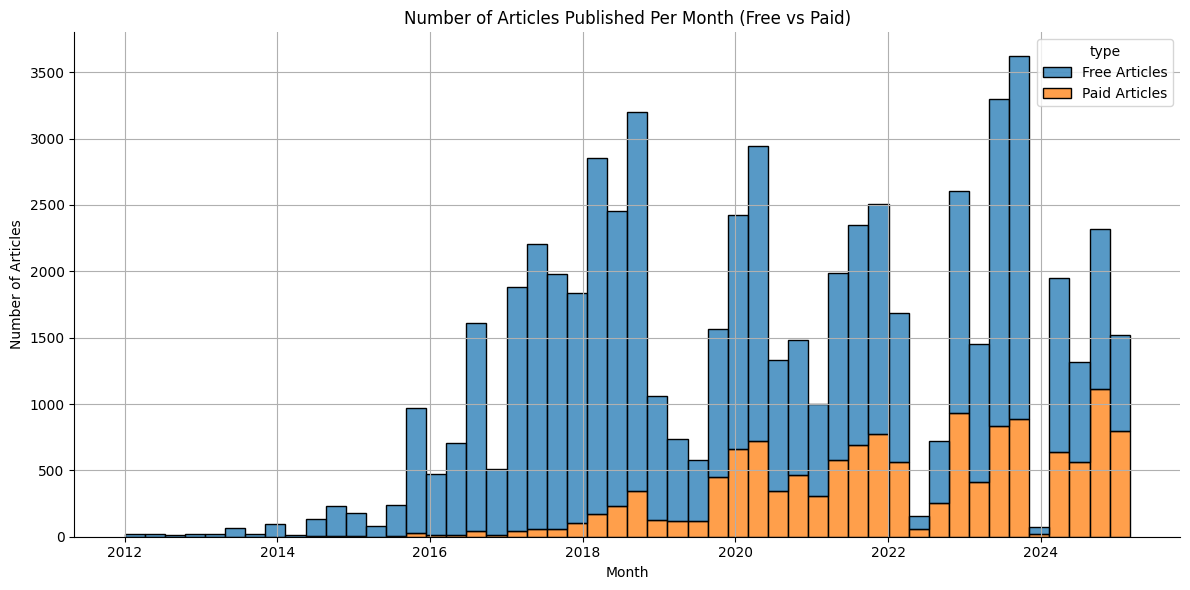

In [8]:
# make sure we have independent DataFrames
free_articles_df = free_articles_df.copy()
paid_articles_df = paid_articles_df.copy()

free_articles_df = free_articles_df[free_articles_df["date_published"] > datetime.datetime(2012, 1, 1)]
paid_articles_df = paid_articles_df[paid_articles_df["date_published"] > datetime.datetime(2012, 1, 1)]

# extract year-month
free_articles_df.loc[:, 'year_month'] = pd.to_datetime(free_articles_df['date_published']).dt.to_period('M')
paid_articles_df.loc[:, 'year_month'] = pd.to_datetime(paid_articles_df['date_published']).dt.to_period('M')

# group by month
free_monthly = free_articles_df.groupby('year_month').size()
paid_monthly = paid_articles_df.groupby('year_month').size()

# build combined DataFrame
free_data = pd.DataFrame({
    'month': free_monthly.index.to_timestamp(),
    'count': free_monthly.values,
    'type': 'Free Articles'
})
paid_data = pd.DataFrame({
    'month': paid_monthly.index.to_timestamp(),
    'count': paid_monthly.values,
    'type': 'Paid Articles'
})
combined_data = pd.concat([free_data, paid_data])

# plot stacked bars
plt.figure(figsize=(12, 6))
sns.histplot(
    data=combined_data,
    x='month',
    weights='count',
    hue='type',
    bins=50,
    multiple='stack',
)
plt.title('Number of Articles Published Per Month (Free vs Paid)')
plt.xlabel('Month')
plt.ylabel('Number of Articles')
sns.despine()
plt.grid(True)
plt.tight_layout()

plt.savefig('../report/images/articles_per_month.png', dpi=300)
plt.show()


In [9]:
articles_filtered = articles_df[articles_df["date_published"] > datetime.datetime(2020, 1, 1)]
articles_filtered = articles_filtered[articles_filtered["language"] == "en"]
print(f"Number of articles published since 2020-01-01 in English: {len(articles_filtered)}")

Number of articles published since 2020-01-01 in English: 33510


In [10]:
free_articles_df = articles_filtered[articles_filtered["is_free"] == True]
paid_articles_df = articles_filtered[articles_filtered["is_free"] == False]

### General Info about data

In [11]:
# get all author IDs that appear in any article
article_author_ids = articles_filtered["author_id"].unique()

# convert to native Python ints for DuckDB
author_ids = [int(x) for x in article_author_ids]

# select only those authors
authors_df = pd.read_sql(
    session.query(Author)
           .filter(Author.id.in_(author_ids))
           .statement,
    session.bind
)
authors_df.shape

(24639, 3)

In [12]:
total_comments = articles_filtered["comments_count"].sum()
print(f"Total comments since 2020-01-01: {total_comments}")

Total comments since 2020-01-01: 83064


In [13]:
# Count how many free vs paid articles (filtered by date and language)
free_count = len(free_articles_df)
paid_count = len(paid_articles_df)

print(f"Free articles: {free_count}")
print(f"Paid articles: {paid_count}")

Free articles: 22248
Paid articles: 11262


### Descriptive statistics

In [15]:
# Compute descriptive statistics for key metrics by premium status
metrics = {
    'claps': 'Clap Count',
    'comments_count': 'Response Count',
    'read_time': 'Reading Time (min)'
}

rows = []
for metric, name in metrics.items():
    for status, df in [('Paid', paid_articles_df), ('Free', free_articles_df)]:
        s = df[metric]
        rows.append({
            'Metric': name,
            'Status': status,
            'N': s.count(),
            'Mean': s.mean(),
            'Median': s.median(),
            'Std. Dev.': s.std()
        })

table1 = pd.DataFrame(rows)
table1

,Metric,Status,N,Mean,Median,Std. Dev.
0,Clap Count,Paid,11262,407.910762,207.0,519.020793
1,Clap Count,Free,22248,122.433118,40.0,272.089520
2,Response Count,Paid,11262,4.938199,2.0,6.965039
3,Response Count,Free,22248,1.233819,0.0,3.064636
4,Reading Time (min),Paid,11262,6.005416,5.0,2.856865
5,Reading Time (min),Free,22248,5.927319,5.0,3.213892


In [16]:
import scipy.stats as stats

# perform Welch’s t-test for each metric
results = []
for metric, name in metrics.items():
    paid_vals = paid_articles_df[metric]
    free_vals = free_articles_df[metric]
    t_stat, p_val = stats.ttest_ind(paid_vals, free_vals, equal_var=False)
    results.append({
        'Metric': name,
        't-statistic': t_stat,
        'p-value': p_val
    })

# tabulate results
ttest_results = pd.DataFrame(results)
print(ttest_results)

               Metric  t-statistic   p-value
0          Clap Count    54.690392  0.000000
1      Response Count    53.863954  0.000000
2  Reading Time (min)     2.264893  0.023528
